In [1]:
import sys
import math
import numpy as np
import ceo
import IPython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 365
nPx = n*nLenslet+1
D = 25.
n_radius = nPx
src    = ceo.Source("J",zenith=0.,azimuth=0.,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
#src    = ceo.Source("J",zenith=np.array([6,6])*ceo.constants.ARCMIN2RAD,
#                    azimuth=np.array([0,90])*math.pi/180,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
radial_order = 4
n_zern = (radial_order+1)*(radial_order+2)/2
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)
#wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

### Initialize and Calibrate Dispersed Fringe Sensor (DFS)

In [3]:
sps_fov = 3.0 #arcsec diameter
sps_dispersion = 5.0
sps = ceo.DispersedFringeSensor(gmt.M1,src, dispersion=sps_dispersion, 
                                field_of_view=sps_fov)#,nyquist_factor=2)
sps.INIT_ALL_ATTRIBUTES = True
sps.lobe_detection = 'peak_value'
sps.calibrate(src,gmt)

#### Display all fftlet images and overplot the following:
1) Blue circles: Blob detection (three per fftlet image)
2) Line passing through the three blobs
3) Line perpendicular to the above line, passing between the central and upper-most lobe. 

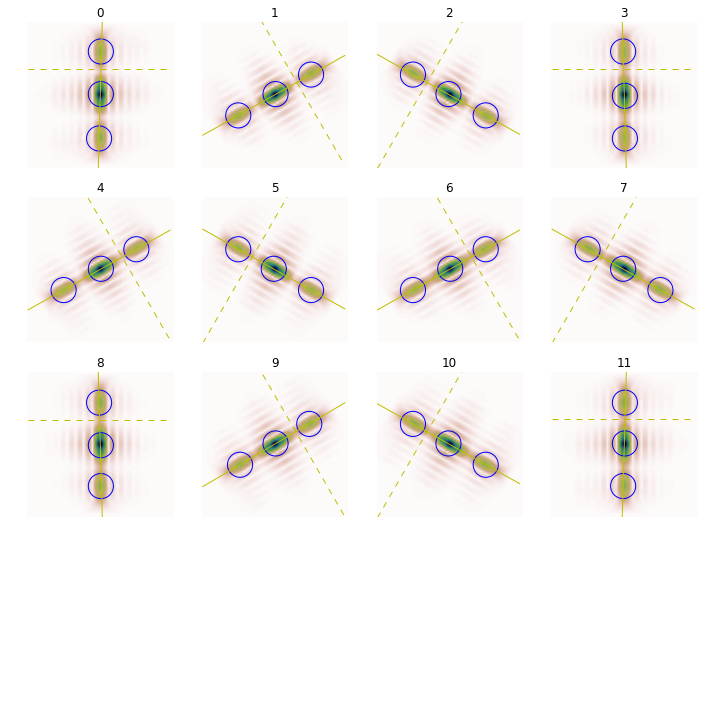

In [4]:
dataCube = sps.get_data_cube(data_type='fftlet')

fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((12,12))
xvec = np.arange(0,sps.camera.N_PX_IMAGE,10)
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=cm.gist_earth_r, origin='lower')
    (ax.ravel())[k].autoscale(False)
    (ax.ravel())[k].plot(xvec, xvec*sps.pl_m[k] + sps.pl_b[k], 'y')
    (ax.ravel())[k].plot(xvec, xvec*sps.pp_m[k] + sps.pp_b[k], 'y--')
    for pp in range(3):
        c1 = Circle((sps.blob_data[k,pp,1], sps.blob_data[k,pp,0]),radius=np.sqrt(2)*sps.blob_data[k,pp,2], 
                    color='b', fill=False)    
        (ax.ravel())[k].add_patch(c1)
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

#### Show the calibrated masks
The masks leave only the upper-most lobe, a.k.a. the detection lobe, visible.

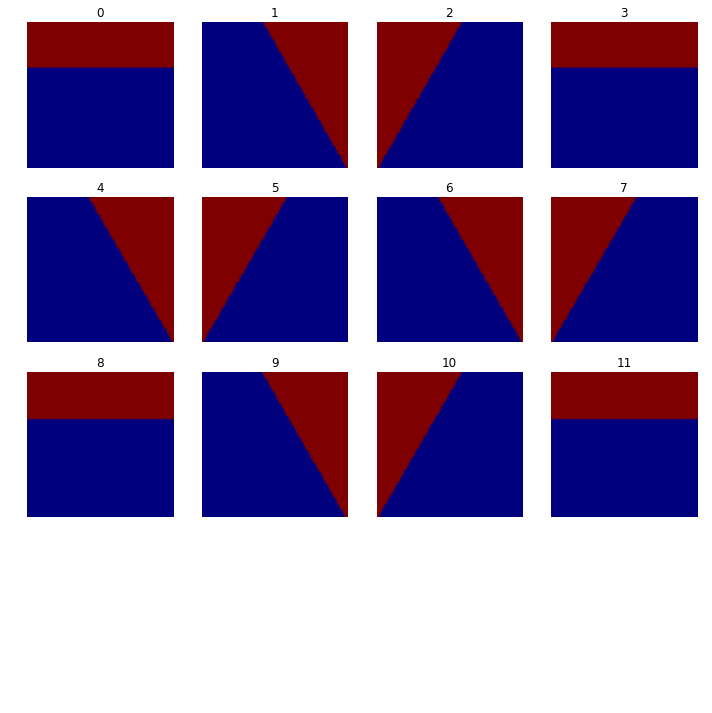

In [5]:
fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((12,12))
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(sps.spsmask[:,:,k], origin='lower')
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

### Compute the DFS reference position vector
The detection lobes are shown below, with the contour of the best-fit 2D Gaussian overplotted.

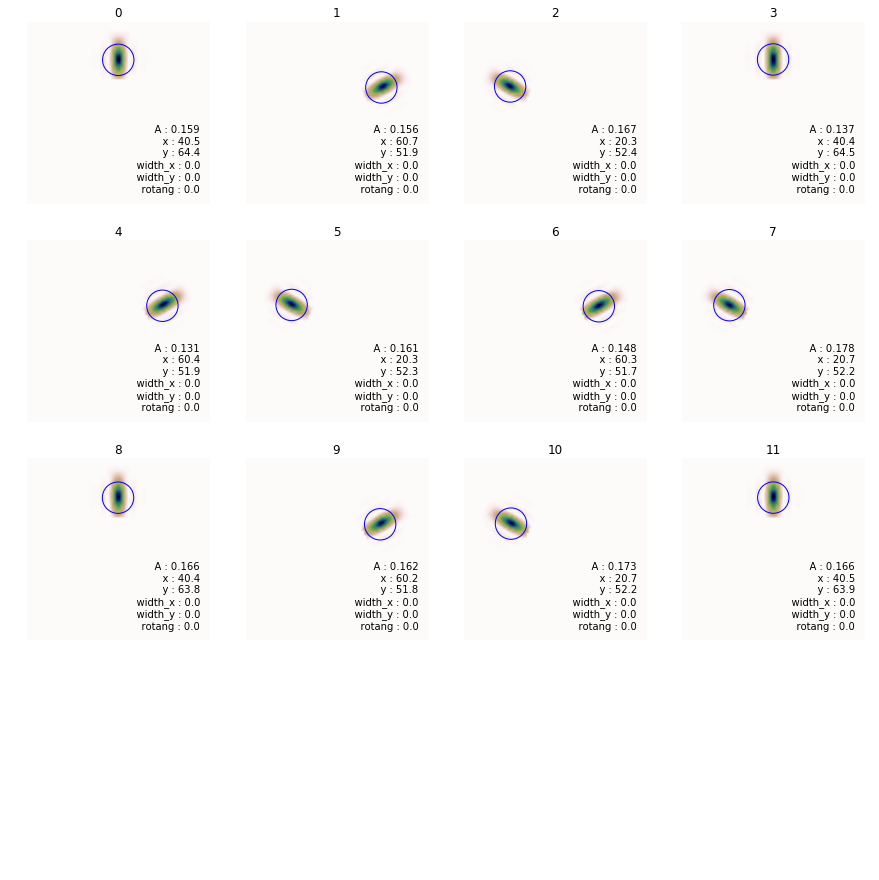

In [6]:
gmt.reset()
src.reset()
gmt.propagate(src)
sps.reset()
sps.analyze(src)
SPSmeas_ref = sps.measurement 

dataCube = sps.get_data_cube(data_type='fftlet')
fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((15,15))
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(dataCube[:,:,k]*sps.spsmask[:,:,k], cmap=plt.cm.gist_earth_r, origin='lower')
    if sps.lobe_detection == 'peak_value':
        c1 = Circle((sps.fftlet_fit_params[2,k], sps.fftlet_fit_params[1,k]),
                radius=np.sqrt(2)*sps.blob_data[k,0,2], color='b', fill=False)    
        (ax.ravel())[k].add_patch(c1)
    elif sps.lobe_detection == 'gaussfit':
        (ax.ravel())[k].contour(sps.fftlet_fit_images[:,:,k], cmap=plt.cm.copper, origin='lower')
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)
    params = sps.fftlet_fit_params[:,k]
    text(0.95, 0.05, """
    A : %.3f
    x : %.1f
    y : %.1f
    width_x : %.1f
    width_y : %.1f
    rotang : %.1f""" %(params[0], params[2], params[1], params[4], params[3], params[5]),
        fontsize=10, horizontalalignment='right',
        verticalalignment='bottom', transform=(ax.ravel())[k].transAxes)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Segment Piston Rec:
(6, 12)


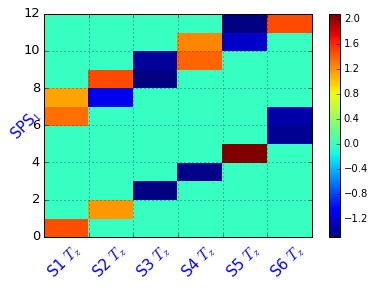

In [7]:
# Calibrate Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m
D_M1_PS = gmt.calibrate(sps, src, mirror="M1", mode="segment piston", 
                        stroke=PSstroke, segment='edge')

R_M1_PS = np.linalg.pinv(D_M1_PS)
print 'SPS - M1 Segment Piston Rec:'
print R_M1_PS.shape
VISU=True

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    imm = ax.pcolor(D_M1_PS*1e-6)  #in displaced pixels per micron
    ax.grid()
    ax.set_ylim([0,12])
    ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left', fontsize=15, rotation=45, color='b')
    #ax.set_yticks([0,12,24,36])
    ax.tick_params(axis='y', labelsize=13)
    ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    fig.colorbar(imm)

### Explore the capture range of the DFS
Piston a segment from 0 to 20 $\mu$m WF and record the DFS measurement (along with other Gaussian fit outputs).

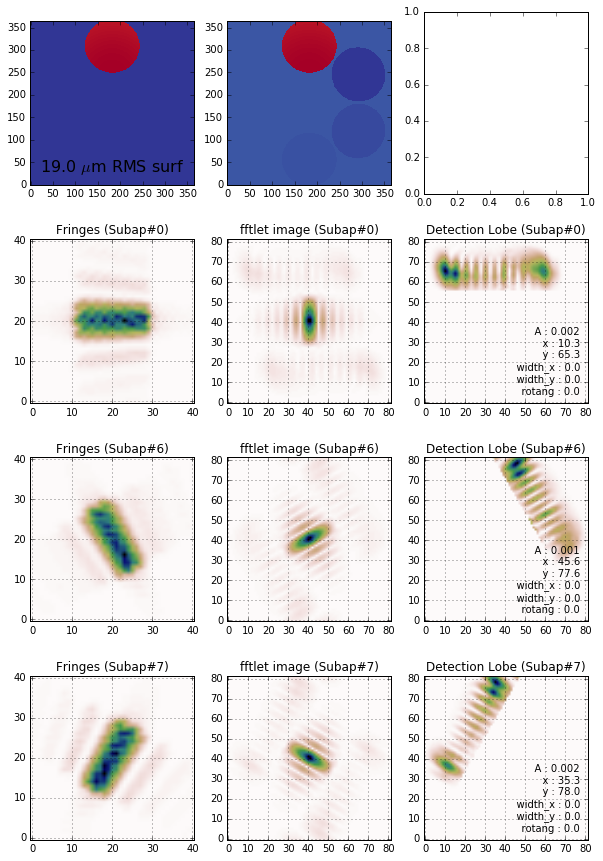

In [8]:
segId = 1 # segment number to scan in piston
subap = [0,6,7] # DFS subaperture to monitor visually
zernidx = 0 # 0: piston, 1: tilt, ...
segStroke = np.arange(0,20.,1.0, dtype=float)  #in microns
SPSmeas = np.zeros((12*src.N_SRC, segStroke.size))
lobeA = np.zeros((12*src.N_SRC, segStroke.size))
SPSrec = np.zeros((6,segStroke.size))
#lobex = np.zeros(segStroke.size)
#lobey = np.zeros(segStroke.size)
#lobewx = np.zeros(segStroke.size)
#lobewy = np.zeros(segStroke.size)

fig, ax = subplots(4,3)
fig.set_size_inches((10,15))
textcoll=[[] for k in range(4)] 
contourcoll=[[] for k in range(3)] 

for pp in range(segStroke.size):
    gmt.reset()
    
    # Apply a Zernike vector to a particular segment on M1
    if zernidx == 0:
        gmt.M1.motion_CS.origin[segId-1,2] = segStroke[pp]*1e-6
        gmt.M1.motion_CS.update()
    else:
        a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
        a_M1[zernidx] = segStroke[pp]*1e-6      # m RMS surf
        gmt.M1.zernike.a[segId-1,:] = a_M1
        gmt.M1.zernike.update()

    src.reset()
    gmt.propagate(src)
    wfin = src.phase.host(units='micron')
    sps.reset()
    sps.analyze(src)
    SPSmeas[:,pp] = sps.measurement - SPSmeas_ref
    SPSrec[:,pp] = np.dot(R_M1_PS, SPSmeas[:,pp].ravel())
    lobeA[:,pp] = sps.fftlet_fit_params[0,:]
    #lobex[pp] = x
    #lobey[pp] = y
    #lobewx[pp] = width_x
    #lobewy[pp] = width_y   

    ### Get the reconstructed WF:
    src.reset()
    gmt.reset()
    for thisSeg in range(6):
        gmt.M1.motion_CS.origin[thisSeg,2] = SPSrec[thisSeg,pp]
    gmt.M1.motion_CS.update()    
    gmt.propagate(src)
    wfrec = src.phase.host(units='micron')

    ### -> For visualization only:
    dataCube = sps.get_data_cube(data_type='fftlet')
    fringesCube = sps.get_data_cube(data_type='camera')
    params = sps.fftlet_fit_params[:,subap]
    if pp > 0:
        for tt in textcoll: tt.remove()
        if sps.lobe_detection == 'gaussfit':
            for tt in contourcoll:
                for coll in tt.collections: coll.remove()
    imm1 = (ax.ravel())[0].imshow(wfin, interpolation='None',cmap='RdYlBu',origin='lower')
    imm2 = (ax.ravel())[1].imshow(wfrec, interpolation='None',cmap='RdYlBu',origin='lower')
    textcoll[0] = text(0.5,0.05, """%.1f $\mu$m RMS surf"""%segStroke[pp], fontsize=16, 
                         verticalalignment='bottom', horizontalalignment='center', transform=(ax.ravel())[0].transAxes)
    for k in range(3):
        (ax.ravel())[3*k+3].imshow((fringesCube[:,:,subap[k]]), cmap=plt.cm.gist_earth_r, origin='lower')
        (ax.ravel())[3*k+4].imshow(np.sqrt(dataCube[:,:,subap[k]]), cmap=plt.cm.gist_earth_r, origin='lower')
        (ax.ravel())[3*k+5].imshow(dataCube[:,:,subap[k]]*sps.spsmask[:,:,subap[k]], cmap=plt.cm.gist_earth_r, origin='lower')
        if sps.lobe_detection == 'gaussfit':
            contourcoll[k] = (ax.ravel())[3*k+5].contour(sps.fftlet_fit_images[:,:,subap[k]], cmap=plt.cm.copper, origin='lower')

        (ax.ravel())[3*k+3].grid(True)
        (ax.ravel())[3*k+3].set_title('Fringes (Subap#%d)'%subap[k])
        (ax.ravel())[3*k+4].grid(True)
        (ax.ravel())[3*k+4].set_title('fftlet image (Subap#%d)'%subap[k])
        (ax.ravel())[3*k+5].grid(True)
        (ax.ravel())[3*k+5].set_title('Detection Lobe (Subap#%d)'%subap[k])
        
        textcoll[k+1] = text(0.95, 0.04, """
            A : %.3f
            x : %.1f
            y : %.1f
            width_x : %.1f
            width_y : %.1f
            rotang : %.1f""" %(params[0,k], params[2,k], params[1,k], params[4,k], params[3,k], params[5,k]),
            fontsize=10, horizontalalignment='right',
            verticalalignment='bottom', transform=(ax.ravel())[3*k+5].transAxes)
    IPython.display.clear_output(wait=True)
    IPython.display.display(fig)

close()

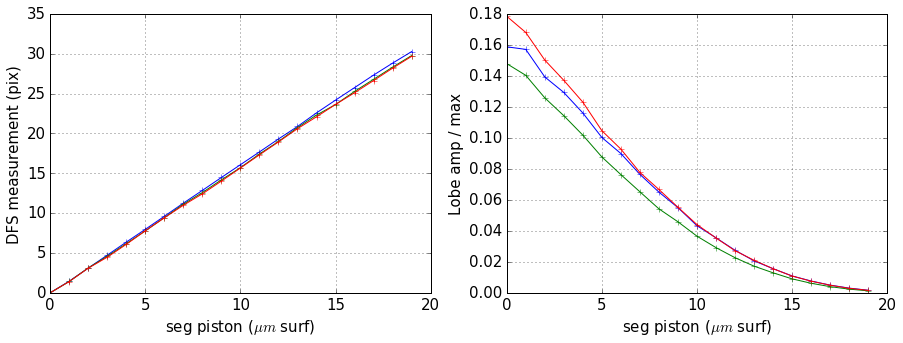

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((15,5))

ax1.plot(segStroke, SPSmeas[subap].T, '-+', label='S')
ax1.set_xlabel('seg piston ($\mu m$ surf)', fontsize=15)
ax1.set_ylabel('DFS measurement (pix)', fontsize=15)
ax1.grid()
ax1.tick_params(labelsize=15)
#ax1.legend()

ax2.plot(segStroke, lobeA[subap].T, '-+')
ax2.grid()
ax2.set_xlabel('seg piston ($\mu m$ surf)', fontsize=15)
ax2.set_ylabel('Lobe amp / max', fontsize=15)
#ax2.set_yscale('log')
ax2.tick_params(labelsize=15)

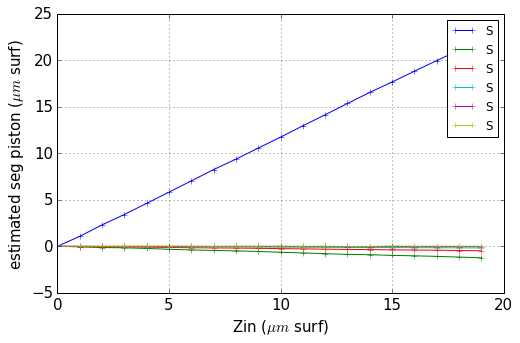

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches((8,5))

ax.plot(segStroke, SPSrec.T *1e6, '-+', label='S')
ax.set_xlabel('Zin ($\mu m$ surf)', fontsize=15)
ax.set_ylabel('estimated seg piston ($\mu m$ surf)', fontsize=15)
ax.grid()
ax.tick_params(labelsize=15)
ax.legend()

In [10]:
#---- Noise propagation coefficients
npc = np.diagonal(np.linalg.pinv(np.dot( np.transpose(D_M1_PS), D_M1_PS)))

print('Segment piston N.P.C. for dispersion %0.1f"/micron: %0.3f microns RMS / signal RMS'%(
        sps_dispersion, np.sqrt(np.mean(npc))*1e6))

Segment piston N.P.C. for dispersion 5.0"/micron: 0.468 microns RMS / signal RMS
